<center><h1>DSCI 552: Machine Learning for Data Science</h1></center><br>
<center>Combined Cycle Power Plant Data Set</center>

<h3>Homework 2</h3>
<p></p>
<b><span>Name: Sri Manvith Vaddeboyina</span></b><br>
<b><span>USC ID: 1231409457</span></b><br>
<b><span>Github username: srimanvithv</span></b>

The dataset contains data points collected from a Combined Cycle Power Plant over
6 years (2006-2011), when the power plant was set to work with full load. Features
consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP),
Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical
energy output (EP) of the plant.

<b>(a) Download the Combined Cycle Power Plant data from: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant </b>

<b>Import necessary packages/libraries</b>

In [1]:
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor as KNNRegression
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

In [2]:
ccp_df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx', index_col=None)
ccp_df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


# 

<b>(b) Exploring the data:</b>

<b>i. How many rows are in this data set? How many columns? What do the rows and columns represent?</b>

In [3]:
print("\033[1mNumber of rows: ", ccp_df.shape[0])
print()
print("\033[1mNumber of rows: ", ccp_df.shape[1])
print()
print("\033[1mEach row represents a sample point (observation) for each of the features (AT, V, AP, RH, PE)")
print()
print('\033[1mEach column represents a specific feature. The dataset comprises four hourly average ambient variables: Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V). The column labeled PE corresponds to the net hourly electrical energy output of the plant.')

Number of rows:  9568

Number of rows:  5

Each row represents a sample point (observation) for each of the features (AT, V, AP, RH, PE)

Each column represents a specific feature. The dataset comprises four hourly average ambient variables: Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V). The column labeled PE corresponds to the net hourly electrical energy output of the plant.


<p></p>

<b>ii. Make pairwise scatterplots of all the variables in the data set including the
predictors (independent variables) with the dependent variable. Describe
your findings.</b>

Scatter plot of all independent variables with dependent variable


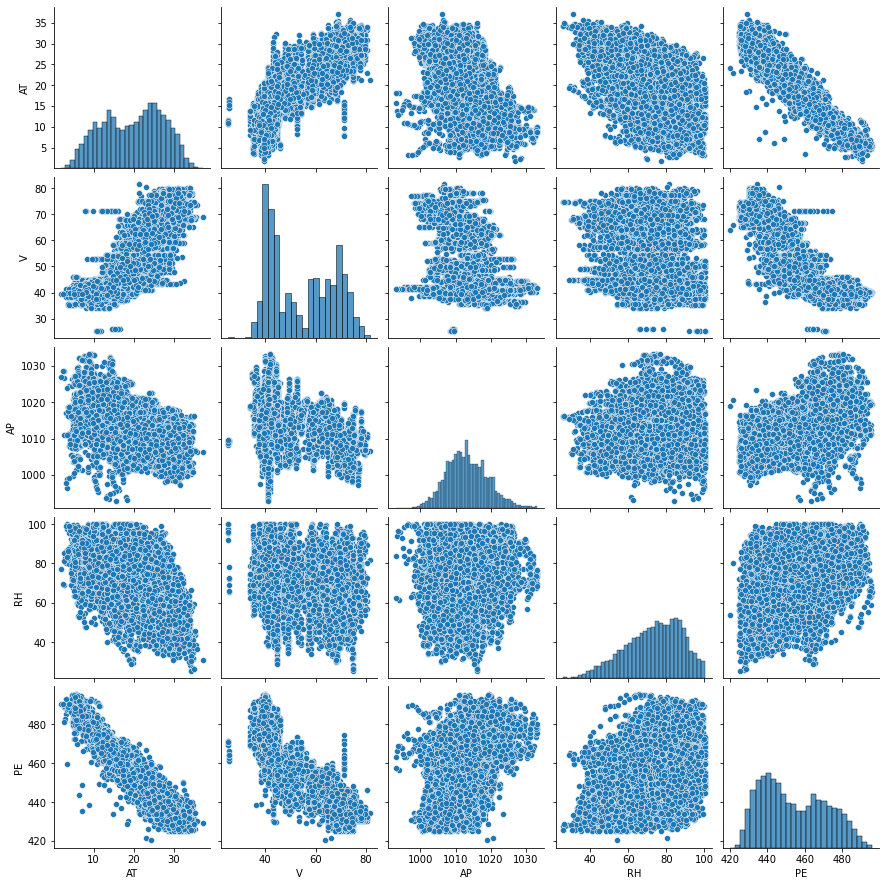

In [35]:
sns.pairplot(ccp_df)
print("\033[1mScatter plot of all independent variables with dependent variable")

<b>Key Findings:</b><br>

- <b>Temperature (AT) has a positive correlation with Exhaust Vacuum (V) and a negative correlation with net hourly electrical energy output (PE). V also negatively correlates with PE.</b>

- <b>Strong linear relationships exist between PE and AT, while PE and Relative Humidity (RH) lack a direct linear relationship. PE and V have a moderate linear relationship with noticeable outliers.</b>

- <b>Scatter plots for PE vs. AT, PE vs. V, and V vs. AT show low variance, indicating data concentration, while scatter plots for PE vs. Ambient Pressure (AP), PE vs. RH, etc., have higher variance, suggesting potential outliers.</b>

- <b>Visual trends reveal that as AT increases, PE tends to decrease, and there appears to be an inverse relationship between V and PE, implying that higher V is associated with lower PE.</b>

<b>iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them
in a table.</b>

In [5]:
def calculate_summary_stats(df):
    summary = {
        "Mean": np.round(np.mean(df, axis=0), 2),
        "Median": np.round(np.median(df, axis=0), 2),
        "Range": np.round(np.max(df, axis=0) - np.min(df, axis=0), 2),
        "1st Quartile": np.round(np.quantile(df, 0.25, axis=0), 2),
        "3rd Quartile": np.round(np.quantile(df, 0.75, axis=0), 2)
    }
    summary["Interquartile Range (IQR)"] = summary["3rd Quartile"] - summary["1st Quartile"]
    return pd.DataFrame(summary)

summary_df = calculate_summary_stats(ccp_df)
print("\033[1mSummary of variables:")
summary_df

Summary of variables:


,Mean,Median,Range,1st Quartile,3rd Quartile,Interquartile Range (IQR)
AT,19.65,20.34,35.30,13.51,25.72,12.21
V,54.31,52.08,56.20,41.74,66.54,24.80
AP,1013.26,1012.94,40.41,1009.10,1017.26,8.16
RH,73.31,74.97,74.60,63.33,84.83,21.50
PE,454.37,451.55,75.50,439.75,468.43,28.68


# 

<b>(c) For each predictor, fit a simple linear regression model to predict the response.
Describe your results. In which of the models is there a statistically significant
association between the predictor and the response? Create some plots to back
up your assertions. Are there any outliers that you would like to remove from
your data for each of these regression tasks?</b>

In [6]:
X_train_AT, X_train_V, X_train_AP, X_train_RH, y_train = [ccp_df[col].to_numpy() for col in ['AT', 'V', 'AP', 'RH', 'PE']]

In [7]:
def PlotGraph(X, X_const, y, feature_name, outliers_index,model):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X, y, color = "g")
    ax.scatter(X[outliers_index], y[outliers_index], marker = "o", label = "Outliers", color = "b")
    ax.plot(X, model.predict(X_const), linewidth = 4, label = "Regression Line", color = "r")
    ax.set_title("Simple Linear Regression for the feature: " + feature_name)
    ax.set_xlabel(feature_name)
    ax.set_ylabel("PE")
    ax.legend()
    plt.show()

In [8]:
threshold = 4 / len(ccp_df)
univar_regr_coefficients = []

def SimpleLinearRegression(feature_name, X, Y):
    X_const = sm.add_constant(X)
    model = sm.OLS(Y, X_const).fit()
    univar_regr_coefficients.append(model.params[1])
    
    cooks = model.get_influence().cooks_distance
    outliers_index = [i for i, cook_value in enumerate(cooks[0]) if cook_value > threshold]
    outliers_df = pd.DataFrame({feature_name: X[outliers_index], 'PE': Y[outliers_index]})
    
    print("\033[1mModel Summary:\n")
    print(model.summary())
    print()
    print("Note: In the above summary, y: PE, x1: ", feature_name)
    print()
    print("-------------------------------------------------------------------------------------------------------")
    print("\n\n\033[1mOutliers we would like to remove from the data:")
    display(outliers_df)
    print()
    print()
    print("-------------------------------------------------------------------------------------------------------")
    print("\n\n\033[1mSimple Linear Regression Plot:")
    PlotGraph(X, X_const, Y, feature_name, outliers_index,model)

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:09   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3

,AT,PE
0,5.41,495.24
1,29.01,446.22
2,32.72,437.99
3,35.56,429.69
4,27.54,450.22
...,...,...
411,33.20,438.12
412,30.26,442.98
413,34.03,440.29
414,5.01,475.34




-------------------------------------------------------------------------------------------------------


Simple Linear Regression Plot:


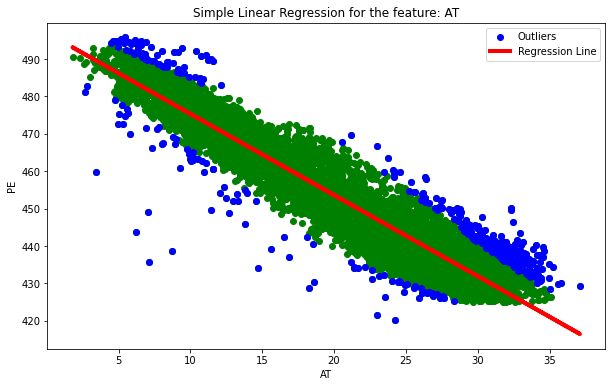

In [9]:
SimpleLinearRegression("AT", X_train_AT, y_train)

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:09   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8015      0.378   1

,V,PE
0,39.40,488.56
1,40.07,495.24
2,48.60,436.06
3,43.43,448.06
4,39.33,491.49
...,...,...
418,75.23,443.78
419,39.72,455.58
420,44.89,445.45
421,43.77,446.05




-------------------------------------------------------------------------------------------------------


Simple Linear Regression Plot:


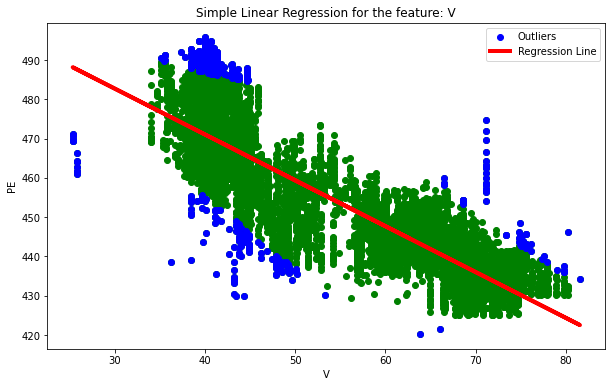

In [10]:
SimpleLinearRegression("V", X_train_V, y_train)

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:09   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.2610     25.459    

,AP,PE
0,1019.16,495.24
1,1008.52,483.80
2,1010.18,491.49
3,1008.82,481.09
4,1001.24,459.36
...,...,...
295,1030.61,464.95
296,1008.43,484.75
297,1005.24,479.22
298,998.27,472.16




-------------------------------------------------------------------------------------------------------


Simple Linear Regression Plot:


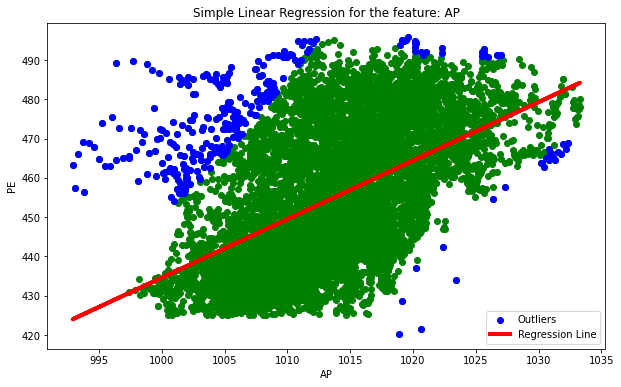

In [11]:
SimpleLinearRegression("AP", X_train_AP, y_train)

Model Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:09   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.9618      0.823    

,RH,PE
0,41.25,475.98
1,43.08,462.19
2,48.84,467.54
3,64.77,495.24
4,50.00,474.60
...,...,...
244,97.21,490.68
245,98.84,490.50
246,90.20,430.55
247,93.39,434.11




-------------------------------------------------------------------------------------------------------


Simple Linear Regression Plot:


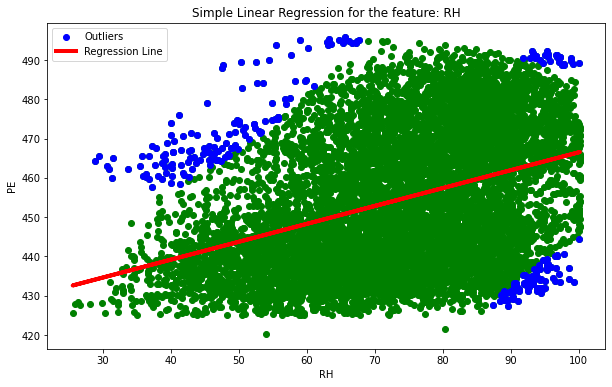

In [12]:
SimpleLinearRegression("RH", X_train_RH, y_train)

<h3><b>Discussion</b></h3><br>

- <b>Based on the p-values, all four models show a statistically significant relationship between the predictors and the response.</b><br>

- <b>Additionally, the R-squared values differ among the models. For AT and V, which have high R-squared values, the models explain a substantial portion of the variance in the response variable, suggesting a strong predictive relationship. In contrast, the models for RH and AP have lower R-squared values, indicating that a significant portion of the variance remains unexplained, resulting in higher unexplained errors.</b><br>

- <b>Furthermore, the negative coefficients for AT and V indicate a negative slope in their relationships with the response variable.</b><br>

- <b>In summary, based on the R-squared values and the significance of predictors in the models, it is evident that the models for AT and V exhibit a statistically significant and stronger association between the predictor variables and the response variable.</b>

# 

<b>(d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?</b>

In [13]:
multivar_regr_coefficients = []

X = ccp_df[ccp_df.columns[:-1]]
Y = ccp_df['PE']
model = sm.OLS(Y, sm.add_constant(X)).fit()

for i in range(1,len(ccp_df.columns)):
    multivar_regr_coefficients.append(model.params[i])
    
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

<h3><b>Discussion</b></h3>

- <b>Given that the p-values for all variables are less than 0.05 (p < 0.05), it is evident that all of them are statistically significant, so we can reject the null hypothesis (H0 : βj = 0) for all predictors.</b><br>

# 

<b>(e) How do your results from 1c compare to your results from 1d? Create a plot
displaying the univariate regression coefficients from 1c on the x-axis, and the
multiple regression coefficients from 1d on the y-axis. That is, each predictor is
displayed as a single point in the plot. Its coefficient in a simple linear regression
model is shown on the x-axis, and its coefficient estimate in the multiple linear
regression model is shown on the y-axis.</b>

In [14]:
univar_regr_coefficients

[-2.1713199585178047,
 -1.1681351265557107,
 1.4898716733991129,
 0.45565010226298014]

In [15]:
multivar_regr_coefficients

[-1.9775131066353864,
 -0.2339164225825025,
 0.06208294378084911,
 -0.15805410291641003]

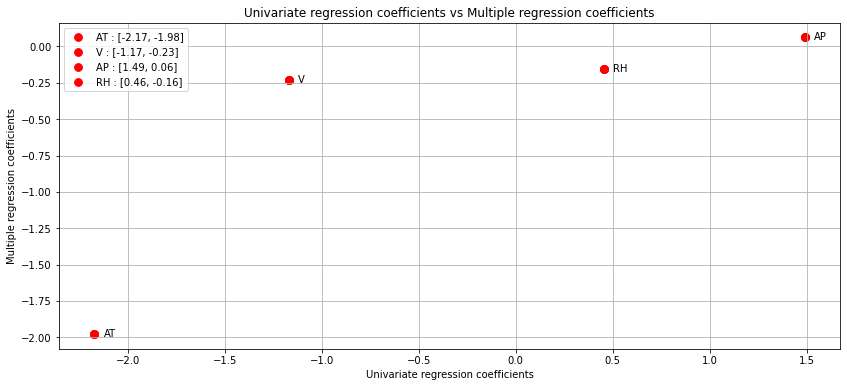

In [16]:
x_offset, y_offset = 9, -2
figure(figsize=(14, 6))

for i, txt in enumerate(ccp_df.columns[:-1]):
    legend_val = f"{txt} : [{np.round(univar_regr_coefficients[i], 2)}, {np.round(multivar_regr_coefficients[i], 2)}]"

    plt.scatter(univar_regr_coefficients, multivar_regr_coefficients, s = 60, c = 'r', label = legend_val)
    plt.annotate(txt, (univar_regr_coefficients[i], multivar_regr_coefficients[i]), xytext=(x_offset, y_offset), textcoords='offset points')
    plt.title('Univariate regression coefficients vs Multiple regression coefficients')
    plt.xlabel('Univariate regression coefficients')
    plt.ylabel('Multiple regression coefficients')
    plt.grid(True)
    plt.legend() 

# 

<b>(f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form </b><br>
<center>$Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$</center>


In [17]:
def fit_polynomial_regression(feature_name):
    X = ccp_df[feature_name].to_numpy().reshape(-1, 1)
    y = ccp_df["PE"].to_numpy()
    
    poly = PolynomialFeatures(3)
    X_poly = poly.fit_transform(X)
    
    model = sm.OLS(y, X_poly).fit()
    
    print(model.summary())

In [18]:
fit_polynomial_regression("AT")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

Note: In the above summary, y: PE, x1: $AT$, x2: $AT^2$, x3: $AT^3$

In [19]:
fit_polynomial_regression("V")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

Note: In the above summary, y: PE, x1: $V$, x2: $V^2$, x3: $V^3$

In [20]:
fit_polynomial_regression("AP")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

Note: In the above summary, y: PE, x1: $AP$, x2: $AP^2$, x3: $AP^3$

In [21]:
fit_polynomial_regression("RH")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

Note: In the above summary, y: PE, x1: $RH$, x2: $RH^2$, x3: $RH^3$

<h3>Note: </h3>

x = $x$<br>
x2 = $x^2$<br>
x3 = $x^3$,  &nbsp; where x : predictor

<h3><b>Discussion</b></h3>

1. **Significance of 'AT,' 'AP,' and 'RH':** The small p-values for 'AT,' 'AP,' and 'RH' indicate a strong statistical basis to reject the null hypothesis. This means there is substantial evidence supporting a non-linear association between these predictor variables and the response, suggesting that these factors exhibit meaningful non-linear patterns in explaining the response variable's variations.
<br>
2. **'V' and Its Non-Linear Association:** Conversely, for 'V,' the p-values for 𝑥2 and 𝑥3 are not negligible, particularly 𝑥2. This implies that there is insufficient statistical evidence to reject the null hypothesis for 'V.' In practical terms, this suggests that 'V' does not exhibit a significant non-linear relationship with the response variable, particularly when considering 𝑥2.


# 

<b>(g) Is there evidence of association of interactions of predictors with the response? To
answer this question, run a full linear regression model with all pairwise interaction
terms and state whether any interaction terms are statistically significant.</b>

In [22]:
target = "PE"
predictors = ccp_df.columns[:-1]
formula = f"{target} ~ {' + '.join(predictors)} + {' + '.join([f'{x}*{y}' for x in predictors for y in predictors if x != y])}"
model = smf.ols(formula = formula, data = ccp_df).fit()    
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

<h3><b>Discussion</b></h3>

<b>Based on the analysis of p-values at different significance levels:</b>
- <b>Features such as V, AP, RH, and interaction terms AT * V, AT * RH, V * AP, and AP * RH are statistically significant at a p-value threshold of 0.05.</b>
- <b> At a p-value threshold of 0.10, AT and V * RH also become statistically significant.</b>
- <b> However, AT * AP is not statistically significant, as it exhibits an extremely high p-value. </b>

# 

<b>(h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a
randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities,
and remove insignificant variables using p-values (be careful about interaction
terms). Test both models on the remaining points and report your train and test
MSEs.</b>

In [23]:
ccp_df_train, ccp_df_test = train_test_split(ccp_df, train_size = 0.7, random_state = 3940)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.7, random_state = 3940)

In [25]:
results_df = pd.DataFrame(columns=["Formula", "Train MSE", "Test MSE"])
all_results_df = pd.DataFrame(columns=["Model", "Train MSE", "Test MSE"])

In [26]:
def regression_model(formula):
    model = smf.ols(formula = formula, data = ccp_df_train).fit()
    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_predictions)
    mse_test = mean_squared_error(y_test, y_test_predictions)
    print()
    print(model.summary())
    print()
    print("\033[1mFormula: "+str(formula))
    print("\033[1mTrain MSE: "+str(mse_train))
    print("\033[1mTest MSE: "+str(mse_test))
    print()
    return mse_train, mse_test

In [27]:
formula = f"PE ~ {' + '.join(predictors)}"
mse_train, mse_test = regression_model(formula)
results_df = results_df.append({"Formula": formula, "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)
all_results_df = all_results_df.append({"Model": "Linear Regression (all)", "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -19688.
No. Observations:                6697   AIC:                         3.939e+04
Df Residuals:                    6692   BIC:                         3.942e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    459.5592     11.691     39.309      0.

In [28]:
quadratic_terms = [f'np.power({var}, 2)' for var in predictors]
interaction_terms = [f'{var1}*{var2}' for var1 in predictors for var2 in predictors if var1 < var2]

formula = f"PE ~ {' + '.join(predictors)} + {' + '.join(quadratic_terms)} + {' + '.join(interaction_terms)}"
mse_train, mse_test = regression_model(formula)
results_df = results_df.append({"Formula": formula, "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)
all_results_df = all_results_df.append({"Model": "Linear Regression (all possible interaction terms and quadratic nonlinearities)", "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7169.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -19227.
No. Observations:                6697   AIC:                         3.848e+04
Df Residuals:                    6682   BIC:                         3.859e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8412.1324   1465.630    

- <b>If the significance level exceeds 0.05, we opt to exclude the terms $V^2$, (AP * AT), (AP * V), and (RH * V) from the model. It's worth noting that we retain the feature 'V' as it is basic predictor and the presence of the interaction term (AT * V) with a low p-value, which justifies its inclusion.</b><br><br>

In [29]:
formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH'

mse_train, mse_test = regression_model(formula)
results_df = results_df.append({"Formula": formula, "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)
all_results_df = all_results_df.append({"Model": "Linear Regression (remove insignificant variables)", "Train MSE": mse_train, "Test MSE": mse_test}, ignore_index=True)


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.003e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:14:10   Log-Likelihood:                -19230.
No. Observations:                6697   AIC:                         3.848e+04
Df Residuals:                    6686   BIC:                         3.856e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.044e+04   1105.132    

In [30]:
print("\033[1mResults:")
results_df

Results:


,Formula,Train MSE,Test MSE
0,PE ~ AT + V + AP + RH,20.941456,20.367589
1,"PE ~ AT + V + AP + RH + np.power(AT, 2) + np.power(V, 2) + np.power(AP, 2) + np.power(RH, 2) + AT*V + AT*RH + AP*AT + AP*V + AP*RH + RH*V",18.247801,17.798417
2,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH",18.263546,17.870494


# 

<b>(i) KNN Regression:</b><br>
    
  i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2, . . . ,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

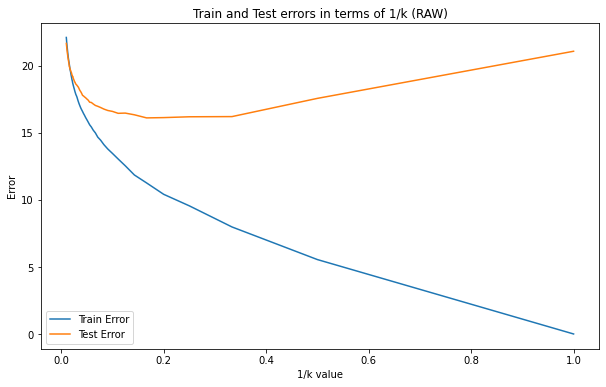

Best K: 6.0
Minimum Train MSE: 11.266589390771992
Minimum Test MSE: 16.11769372653741


In [31]:
oneuponk_value_raw = []
train_errors_raw = []
test_errors_raw = []
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, random_state = 3940)

for k_value in range(1,101,1):
    oneuponk_value_raw.append(1/k_value)
    KNN_model = KNNRegression(n_neighbors = k_value)
    KNN_model.fit(X_train_raw, y_train_raw)
    train_errors_raw.append(mean_squared_error(y_train_raw, KNN_model.predict(X_train_raw)))
    test_errors_raw.append(mean_squared_error(y_test_raw, KNN_model.predict(X_test_raw)))

figure(figsize=(10, 6))         
plt.plot(oneuponk_value_raw, train_errors_raw, label = 'Train Error')
plt.plot(oneuponk_value_raw, test_errors_raw, label = 'Test Error')
plt.title('Train and Test errors in terms of 1/k (RAW)') 
plt.xlabel('1/k value')
plt.ylabel('Error')
plt.legend()
plt.show()

print("\033[1mBest K:", 1/(oneuponk_value_raw[test_errors_raw.index(min(test_errors_raw))]))
print("\033[1mMinimum Train MSE:", train_errors_raw[test_errors_raw.index(min(test_errors_raw))])
print("\033[1mMinimum Test MSE:", min(test_errors_raw))
all_results_df = all_results_df.append({"Model": "KNN (raw features)", "Train MSE": train_errors_raw[test_errors_raw.index(min(test_errors_raw))],"Test MSE": min(test_errors_raw)}, ignore_index=True)

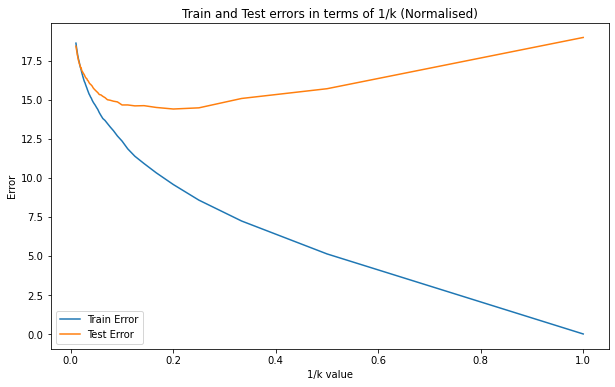

Best K: 5.0
Minimum Train MSE: 9.574226620875018
Minimum Test MSE: 14.410762683385585


In [32]:
oneuponk_value_norm = []
train_errors_norm = []
test_errors_norm = []

minmax_scaler = MinMaxScaler()
X_norm = minmax_scaler.fit_transform(X)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, Y, train_size = 0.7, random_state = 3940)

for k_value in range(1,101,1):
    oneuponk_value_norm.append(1/k_value)
    KNN_model = KNNRegression(n_neighbors = k_value)
    KNN_model.fit(X_train_norm, y_train_norm)
    train_errors_norm.append(mean_squared_error(y_train_norm, KNN_model.predict(X_train_norm)))
    test_errors_norm.append(mean_squared_error(y_test_norm, KNN_model.predict(X_test_norm)))

figure(figsize=(10, 6))         
plt.plot(oneuponk_value_norm, train_errors_norm, label = 'Train Error')
plt.plot(oneuponk_value_norm, test_errors_norm, label = 'Test Error')
plt.title('Train and Test errors in terms of 1/k (Normalised)') 
plt.xlabel('1/k value')
plt.ylabel('Error')
plt.legend()
plt.show()

print("\033[1mBest K:", 1/(oneuponk_value_norm[test_errors_norm.index(min(test_errors_norm))]))
print("\033[1mMinimum Train MSE:", train_errors_norm[test_errors_norm.index(min(test_errors_norm))])
print("\033[1mMinimum Test MSE:", min(test_errors_norm))
all_results_df = all_results_df.append({"Model": "KNN (normalized features)", "Train MSE": train_errors_norm[test_errors_norm.index(min(test_errors_norm))],"Test MSE": min(test_errors_norm)}, ignore_index=True)

# 

<b>(j) Compare the results of KNN Regression with the linear regression model that has
the smallest test error and provide your analysis.</b>

In [33]:
print("\033[1mResults:")
all_results_df

Results:


,Model,Train MSE,Test MSE
0,Linear Regression (all),20.941456,20.367589
1,Linear Regression (all possible interaction terms and quadratic nonlinearities),18.247801,17.798417
2,Linear Regression (remove insignificant variables),18.263546,17.870494
3,KNN (raw features),11.266589,16.117694
4,KNN (normalized features),9.574227,14.410763


<h3><b>Discussion</b></h3>

- <b>KNN Regression demonstrates superior performance with the least test MSE of 14.41, whereas Linear Regression achieves a minimum test MSE of 17.80. This suggests that KNN outperforms Linear Regression.</b>

- <b>Normalization of features enhances KNN's performance, as seen with KNN (normalized features) having a test MSE of 14.41 compared to KNN (raw features) with a test MSE of 16.12.</b>

- <b>KNN is a non-parametric model, while LR is parametric. However, KNN is computationally more intensive than Linear Regression, necessitating consideration of resource constraints.<b>

- <b>The optimal K value for KNN is K = 5, resulting in the lowest test error. It's important to note that smaller K values may lead to overfitting, and this should be taken into account.<b>

- <b>The superior performance of KNN Regression could be attributed to the non-linear nature of the data, as KNN has the flexibility to capture non-linear relationships effectively.<b>

# 

<b>2. ISLR: 2.4.1</b>

<b>(a) The sample size n is extremely large, and the number of predictors p is small.</b><br>
    
- <b>Answer: BETTER</b>, Flexible methods tend to perform better when dealing with a large sample size (n) and a small number of predictors (p). The large sample size helps mitigate the risk of overfitting, which is a common challenge with flexible models. Additionally, in scenarios with limited predictors, flexible models can capture interactions and patterns more effectively, leading to improved fit and predictive accuracy. In such cases, opting for a flexible method is generally the better choice, as inflexible methods may suffer from underfitting in large sample sizes.

<b>    (b) The number of predictors p is extremely large, and the number of observations n is small. </b>
- <b>Answer: WORSE</b>, In the context of a small sample size (n) and a large number of predictors (p), flexible model will perform worse than an inflexible model as flexible model will overfit to the training data.

<b>    (c) The relationship between the predictors and response is highly non-linear. </b>
- <b>Answer: BETTER</b>, In situations where data exhibits strong non-linear relationships between predictors and the response variable, flexible models tend to perform better than inflexible ones. Flexible models excel at capturing complex interactions and accommodating non-linear patterns, making them the preferred choice for such datasets. Therefore, when dealing with non-linear data, using a flexible model is the better option for achieving accurate modeling and predictions.

<b>(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.</b>
- <b>Answer: WORSE</b>, In this scenario, the performance of a flexible statistical learning method is worse than an inflexible method. This is because a high variance of the error terms indicates a lot of noise in the data, and flexible models are more likely to overfit, fitting noise rather than true patterns, which hinders their performance. Inflexible models tend to be less affected by high-variance data and can perform better in such cases.

# 

<b>3. ISLR: 2.4.7</b>

<b>(a) Compute the Euclidean distance between each observation and the test point, $X1 = X2 = X3 =0$.</b>

In [34]:
X_data = [
    [0, 3, 0],
    [2, 0, 0],
    [0, 1, 3],
    [0, 1, 2],
    [-1, 0, 1],
    [1, 1, 1]
]

test_point = [[0, 0, 0]]


euclidean_distance_result = euclidean_distances(X_data, test_point)
euclidean_distance_values = euclidean_distance_result.tolist()

print("\033[1mEuclidean distance between each observation and the test point using library:")

for i in range(len(euclidean_distance_values)):
    print("  Observation "+str(i+1)+": "+ str(euclidean_distance_values[i][0]))

Euclidean distance between each observation and the test point using library:
  Observation 1: 3.0
  Observation 2: 2.0
  Observation 3: 3.1622776601683795
  Observation 4: 2.23606797749979
  Observation 5: 1.4142135623730951
  Observation 6: 1.7320508075688772


<b>Euclidean distance between each observation and the test point using formula:</b>

Observation 1:
$ Distance = \sqrt { (3)^2 }\, = 3$  

Observation 2:
$ Distance = \sqrt { (2)^2 }\, = 2$  

Observation 3:
$ Distance = \sqrt { (1)^2 + (3)^2 }\, = 3.16$  

Observation 4:
$ Distance = \sqrt { (1)^2 + (2)^2 }\, = 2.23$

Observation 5:
$ Distance = \sqrt { (-1)^2 + (1)^2 }\, = 1.41$    

Observation 6:
$ Distance = \sqrt { (1)^2 + (1)^2 + (1)^2 }\, = 1.73$

<b>(b) What is our prediction with K = 1? Why?</b><br>

<b>Answer:</b> For K = 1, the prediction would be <b>Green</b> as the nearest point to the test point (X1, X2, X3) = (0, 0, 0) is

        Observation 5 (X1, X2, X3) = (-1, 0, 1).

<b>(c) What is our prediction with K = 3? Why?</b><br>

<b>Answer:</b> For K = 3, the prediction would be <b>Red</b> as the 3 nearest points to the test point (X1, X2, X3) = (0, 0, 0) are <br>

    Observation 5 (X1, X2, X3) = (-1, 0, 1) : Green
    Observation 6 (X1, X2, X3) = (1, 1, 1)  : Red
    Observation 2 (X1, X2, X3) = (2, 0, 0)  : Red
According to majority polling (Red), output is Red.

<b>(d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?</b><br>

<b>Answer:</b> Given the the problem's decision boundary is highly non-linear, it is advisable to choose a smaller value for K. A smaller K enhances flexibility and helps the model better fit the non-linear data, whereas a larger K tends to produce a more linear boundary by considering more neighbors, which may not be suitable.

<center><b>Thank You</b></center>